In [1]:
# Import a whole load of useful packages
import numpy as np 
import pandas as pd
from netCDF4 import Dataset
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import os.path
import re
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import glob
import itertools
from matplotlib.pyplot import cm
from matplotlib.ticker import LogFormatter
import matplotlib.colors
from scipy.interpolate import griddata 
from scipy.fft import fft, ifft, fft2, ifft2, fftshift, fftfreq
from scipy import signal
from scipy.optimize import minimize
kw = dict(origin='lower', aspect='auto') # Some standards for imshow plots

In [2]:
# Create arrays of transfer functions
def Tsb(k,l, alpha_s, C):
    j2 = k ** 2 + l ** 2
    TSBtop = k * ( 1 + m * (1 + 2 * j2 * C))
    TSBbase = k + m * (k + (2 * k * j2 * C) + ((complex(0,1)) * j2 * (1/np.tan(alpha_s))))
    TSB = TSBtop/TSBbase
    return TSB    

def Tub(k,l, alpha_s, C):
    l2 = l**2
    k2 = k ** 2
    j2 = k ** 2 + l ** 2
    cot = (1/np.tan(alpha_s))
    TUBtop = complex(0,-1) * cot * ((m * l2) - (k2 * (1 + 0.5 * j2 * m * C)))
    TUBbase1 = k + m * (k + (2 * k * j2 * C) + (complex(0,1) * j2 * cot))
    TUBbase2 = ((1/(m*C))+ 0.5 * j2) 
    TUBbase = TUBbase1 * TUBbase2
    TUB = TUBtop/TUBbase
    return TUB

def Tvb(k,l, alpha_s, C):
    j2 = l ** 2 + k ** 2 
    cot = (1/np.tan(alpha_s))
    TVBtop = complex(0,1) * k * l * cot * (1 + m + (0.5 * j2 * C * m))
    TVBbase1 = k + m * (k + (2 * k * j2 * C) + (complex(0,1) * j2 * cot))
    TVBbase2 = ((1/(m*C))+ 0.5 * j2) 
    TVBbase = TVBbase1 * TVBbase2
    TVB = TVBtop/TVBbase
    return TVB

def Tsc(k,l, alpha_s, C):
    j2 = k **2 + l **2 
    cot = (1/np.tan(alpha_s))
    TSCbase = k + m * (k + (2 * k * j2 * C) + (complex(0,1) * j2 * cot))
    TSC = k/TSCbase
    return TSC

def Tuc(k,l, alpha_s, C):
    j2 = l ** 2 + k **2
    l2 = l ** 2
    cot = (1/np.tan(alpha_s))
    TUCtop1 = C* k * (3 * l2 * m * C + 2 + j2 * m * C)
    TUCtop2 = C * complex(0,1) * 2 * l2 * cot * m 
    TUCtop = TUCtop1 + TUCtop2
    TUCbase1 = k + m * (k + (2 * k * j2 * C) + (complex(0,1) * j2 * cot))
    TUCbase2 = (2 + j2 * m * C)
    TUCbase = TUCbase1 * TUCbase2
    TUC = TUCtop/TUCbase
    return TUC

def Tvc(k,l, alpha_s, C):
    j2 = l ** 2 + k ** 2
    cot = (1/np.tan(alpha_s))
    TVCtop = - k * l * m * C * (2 * complex(0,1) * cot + 3 * k * C)
    TVCbase1 = k + m * (k + (2 * k * j2 * C) + (complex(0,1) * j2 * cot))
    TVCbase2 = ((2+ j2 * m * C) )
    TVCbase = TVCbase1 * TVCbase2
    TVC = TVCtop/TVCbase
    return TVC

In [3]:
# Create arrays of reverse transfer functions/the determinant for the inversion
def calcLM_KK(er, k, l, alpha_s, C, rLM_KK= True, BtrueCfalse = True):
    err_S = er
    err_U = 1
    err_V = 1
    ES_sq = (1/err_S)** 2
    EU_sq = (1/err_U)** 2
    EV_sq = (1/err_V)** 2
    TSB = Tsb(k,l, alpha_s, C);
    TUB = Tub(k,l, alpha_s, C);
    TVB = Tvb(k,l, alpha_s, C);
    TSC = Tsc(k,l, alpha_s, C);
    TUC = Tuc(k,l, alpha_s, C);
    TVC = Tvc(k,l, alpha_s, C);
    L = (TSB * np.conj(TSB) * ES_sq) + (TUB * np.conj(TUB) * EU_sq) \
        + (TVB * np.conj(TVB) * EV_sq)
    M = (TSC * np.conj(TSC) * ES_sq) + (TUC * np.conj(TUC) * EU_sq) \
        + (TVC * np.conj(TVC) * EV_sq)
    K = (TSC * np.conj(TSB) * ES_sq) + (TUC * np.conj(TUB) * EU_sq)\
        + (TVC * np.conj(TVB) * EV_sq)
    LM_KK = (L * M) - (K * np.conj(K))
    LM_KK_inv = 1/LM_KK
    TBS = (LM_KK_inv) * (M * np.conj(TSB) - K * np.conj(TSC)) * ES_sq
    TBU = (LM_KK_inv) * (M * np.conj(TUB) - K * np.conj(TUC)) * EU_sq
    TBV = (LM_KK_inv) * (M * np.conj(TVB) - K * np.conj(TVC)) * EV_sq
    TCS = (LM_KK_inv) * (L * np.conj(TSC) - np.conj(K) * np.conj(TSB)) * ES_sq
    TCU = (LM_KK_inv) * (L * np.conj(TUC) - np.conj(K) * np.conj(TUB)) * EU_sq
    TCV = (LM_KK_inv) * (L * np.conj(TVC) - np.conj(K) * np.conj(TVB)) * EV_sq
    TBS[:,0] = 0 + 0j
    TBU[:,0] = 0 + 0j
    TBV[:,0] = 0 + 0j
    TCS[:,0] = 0 + 0j
    TCU[:,0] = 0 + 0j
    TCV[:,0] = 0 + 0j
    if rLM_KK == True:
        return LM_KK
    else:
        if BtrueCfalse == True:
            return TBS, TBU, TBV
        else:
            return TCS, TCU, TCV  

In [4]:
# Create the determinant filter
def filter(p, er, k, l, alpha_s, C, grid):
    LM_KK = calcLM_KK(er, k, l, alpha_s, C, rLM_KK = True, BtrueCfalse=True)
    P = np.nanmax(LM_KK) * (C ** p)
    LM_KK_morethan_P = LM_KK >= P
    LM_KK_lessthan_P = LM_KK <P
    LM_KK_0 = LM_KK / P
    LM_KK_0[LM_KK_morethan_P] = 1 + 0j
    LM_KK_0[0,0] = 0 + 0j
    grid_filt_ft = LM_KK_0 * grid
    grid_filt = ifft2(grid_filt_ft).real
    return grid_filt_ft, grid_filt

In [5]:
def bed_conditions(SURF, VX, VY, THICK, alpha_s, C, erB = 0.0000001, erC = 0.0000001):
    # To avoid edge effects in the Fourier transform smooth down the edges with z
    edge_smoothing = (square_size * tapering)
    edge_w = int(edge_smoothing/spacing)
    tap1 = np.linspace(0,1,edge_w)
    tap2x = np.ones(SURF.shape[1]- 2* edge_w)
    tap2y = np.ones(SURF.shape[0]- 2* edge_w)
    tap3 = np.flip(tap1)
    tapx = np.hstack([tap1,tap2x,tap3])
    tapy = np.hstack([tap1,tap2y,tap3])
    X1, Y1 = np.meshgrid(tapx,tapy)
    z = X1*Y1
    # Correct surface for slope and mean, correct velocities for mean
    S_corr = SURF - x * spacing * slope
    S_corr = S_corr - np.mean(S_corr)
    U_corr = VX - np.mean(VX)
    V_corr = VY - np.mean(VY)
    # Non dimensionalise and smooth edges with z
    S_4inv = S_corr / h_bar * z
    S_4inv = S_4inv - np.mean(S_4inv)
    U_4inv = U_corr / u_bar * z
    U_4inv = U_4inv - np.mean(U_4inv)
    V_4inv = V_corr / u_bar * z
    V_4inv = V_4inv - np.mean(V_4inv)
    # Fourier transform
    S_ft = fft2(S_4inv)
    U_ft = fft2(U_4inv)
    V_ft = fft2(V_4inv)
    # Create the arrays of k and l for the tranfer functions 
    ar1 = np.fft.fftfreq(SURF.shape[1], spacing/h_bar)
    ar2 = np.fft.fftfreq(SURF.shape[0], spacing/h_bar)
    k,l = np.meshgrid(ar1,ar2)
    # Smoothing the input data and weighting it appropriately
    S_filt_ft_b, S_filta_b = filter(p_b, erB, k, l, alpha_s, C, S_ft)
    U_filt_ft_b, U_filta_b = filter(p_b, erB, k, l, alpha_s, C, U_ft)
    V_filt_ft_b, V_filta_b = filter(p_b, erB, k, l, alpha_s, C, V_ft)
    S_filt_ft_c, S_filta_c = filter(p_c, erC, k, l, alpha_s, C, S_ft)
    U_filt_ft_c, U_filta_c = filter(p_c, erC, k, l, alpha_s, C, U_ft)
    V_filt_ft_c, V_filta_c = filter(p_c, erC, k, l, alpha_s, C, V_ft)
    # Calculating the inverse transfer functions
    TBS, TBU, TBV = calcLM_KK(erB, k, l, alpha_s, C, rLM_KK = False, BtrueCfalse = True)
    TCS, TCU, TCV = calcLM_KK(erC, k, l, alpha_s, C, rLM_KK = False, BtrueCfalse = False)
    # Calculating the bed conditions, inverse fourier transform and rescaling
    B_ft = TBV * V_filt_ft_b + TBU * U_filt_ft_b + TBS * S_filt_ft_b
    C_ft = TCV * V_filt_ft_c + TCU * U_filt_ft_c + TCS * S_filt_ft_c
    B_ift = (ifft2(B_ft) * h_bar) #+ x * spacing * slope - (h_bar - np.mean(SURF))
    C_ift = ifft2(C_ft) * C #+ C
    return B_ift, C_ift

In [6]:
# Functions to create beds

def grid_function(x,y, amp, wavelength, angle, mean, form="Chequerboard",\
                  sigma = 500, random_seed = 50, across_lin = 1, along_lin = 1):
    cos_angle = np.cos(np.pi * angle / 180);
    sin_angle = np.sin(np.pi * angle / 180);
    "Create a bed topography, defaults to a chequerboard"
    if form == "Sinewave":
        return mean + amp * np.sin(2 * np.pi * ((y*cos_angle +x*sin_angle)) / (wavelength)) 
    elif form == "None":
        zeros = np.zeros(len(x))
        zerosy = np.zeros(len(y))
        zerox, zeroy = np.meshgrid(zeros,zerosy)
        return zerox 
    elif form =='Random':
        noise1 = new_noise(sigma, random_seed, across_lin, along_lin, True).real
        noise = noise1 - np.mean(noise1)
        return mean + noise/np.max(np.abs(noise)) * amp 
    else: 
        return mean + amp * np.sin(2 *np.pi * x / wavelength) *  np.sin(2 *np.pi * y / wavelength) 
    
    
#Functions to add noise

def gausfilt(u,v,sigma, across_lin, along_lin):    
    return np.exp(((along_lin * u)**2 + (across_lin *v)**2)/(-2*(sigma**2)))
def new_noise(sigma, random_seed, across_lin, along_lin, seed = 'False'):
    """Generates noise with a frequency spectrum determined by sigma"""
    """If seed is set to True then the same noise distribution is used"""
    if seed=='False':
        np.random.seed() # To get random noise
    else:    
        np.random.seed(random_seed) #To get the same set noise distribution
    noise = np.random.normal(0,1,size=(len(x),len(y))) 
    fn = fft2(noise)
    fn_power  = np.sum((fn.real) **2)
    h = fftshift(gausfilt(x,y,sigma, across_lin, along_lin))
    h0 = h * np.sqrt(fn_power /(np.sum(((h*fn).real)**2)))
    noise_cs = ifft2(h0*fn)
    return noise_cs

In [7]:
def tap(bed, gradual = True):
    total_len = bed.shape[0]
    taper_len = int(bed.shape[0] * tapering)
    tap1 = np.linspace(0,1,taper_len)
    tap2 = np.ones(total_len - 2 * taper_len)
    tap0 = np.zeros(taper_len)
    if gradual == True:
        tap = np.hstack([tap1, tap2, np.flip(tap1)])
    else:
        tap = np.hstack([tap0,tap2, tap0])
    def f2(x, y):
        return x * y 
    X1, Y1 = np.meshgrid(tap,tap)
    z = f2(X1,Y1)
    return z

In [8]:
## To make the surface from the bed and slipperiness
def forward_model(bed, slip, alpha_s, C):
    # Calculate the difference to the mean
    bed0 = bed - np.mean(bed)
    slip0 = slip - np.mean(slip)
    # Smooth the edges
    z = tap(bed, True)
    bed_sm = bed0 * z
    slip_sm = slip0 * z
    # Non dimensionalise
    bed_nd = bed_sm / h_bar
    slip_nd = slip_sm / C
    # Do the fourier transforms
    B_fft = fft2(bed_nd)
    C_fft = fft2(slip_nd)
    # Create arrays of k and l 
    ar1 = fftfreq(len(x),spacing/h_bar)
    k, l = np.meshgrid(ar1,ar1)
    TSB_kl = Tsb(k,l, alpha_s, C);
    TSC_kl = Tsc(k,l, alpha_s, C);
    TUB_kl = Tub(k,l, alpha_s, C);
    TVB_kl = Tvb(k,l, alpha_s, C);
    TUC_kl = Tuc(k,l, alpha_s, C);
    TVC_kl = Tvc(k,l, alpha_s, C);
    # Calculate s, u, v
    S_fft = B_fft * TSB_kl + C_fft * TSC_kl
    S_fft[0,0] = 0
    U_fft = B_fft * TUB_kl + C_fft * TUC_kl
    U_fft[0,0] = 0
    V_fft = B_fft * TVB_kl + C_fft * TVC_kl
    V_fft[0,0] = 0
    # Do the inverse transform
    srf = ifft2(S_fft)
    urf = ifft2(U_fft)
    vrf = ifft2(V_fft)
    #Dimensionalise 
    srf1 = srf * h_bar 
    urf1 = urf * u_bar 
    vrf1 = vrf * u_bar 
    return srf1, urf1, vrf1

In [9]:
## Function for b and c
def Identical_twin(bed, slip, alpha_s, C, Noise = False, amp_s = 0, amp_v = 0, sigma = 1000, \
                   erB = 0.0000001, erC = 0.0000001):
    '''This function returns the surface from the forward model and the bed from the inversion'''
    '''If you wish to add Noise to the surface data, set Noise to True'''
    '''Recommended noise levels are ~2m for surface data (REMA is mostly <1m)'''
    '''Recommended noise levels are ~~15m per year for velocity data (ITSLIVE)'''
    '''The sigma parameter allows the wavelength of the noise to be changed'''
    S0, U0, V0 = forward_model(bed, slip, alpha_s, C)
    if Noise == True:
        amplitude_s = amp_s # Recommended 
        amplitude_v = amp_v
    else:
        amplitude_s = 0
        amplitude_v = 0
    noise_s = new_noise(sigma, 14, across_lin = 1, along_lin = 1, seed = True).real
    noise_s = noise_s /np.max(np.abs(noise_s)) * amplitude_s
    noise_u = new_noise(sigma, 15, across_lin = 1, along_lin = 1, seed = True).real
    noise_u = noise_u /np.max(np.abs(noise_u)) * amplitude_v
    noise_v = new_noise(sigma, 16, across_lin = 1, along_lin = 1, seed = True).real
    noise_v = noise_v /np.max(np.abs(noise_v)) * amplitude_v   
    S = S0 + noise_s
    U = U0 + noise_u
    V = V0 + noise_v
    B_inverted, C_inverted = bed_conditions(S, U, V, h_bar, alpha_s, C, erB, erC)
    return S.real, U.real, V.real, B_inverted.real, C_inverted.real

In [10]:
def fit2bed(bed, slip, alpha_s, C, erB, erC):
    fit_B = np.zeros(len(erB))
    B_ifn = np.ndarray(len(erB), dtype = np.ndarray)
    fit_C = np.zeros(len(erB))
    C_ifn = np.ndarray(len(erB), dtype = np.ndarray)
    fit_S = np.zeros(len(erB))
    S_ifn = np.ndarray(len(erB), dtype = np.ndarray)
    S_ifn2 = np.ndarray(len(erB), dtype = np.ndarray)
    fit_U = np.zeros(len(erB))
    U_ifn = np.ndarray(len(erB), dtype = np.ndarray)
    U_ifn2 = np.ndarray(len(erB), dtype = np.ndarray)
    fit_V = np.zeros(len(erB))
    V_ifn = np.ndarray(len(erB), dtype = np.ndarray)
    V_ifn2 = np.ndarray(len(erB), dtype = np.ndarray)
    tap2 = tap(bed, gradual = 'False')
    for i in range(len(erB)):
        S_ifn[i], U_ifn[i], V_ifn[i], B_ifn[i], C_ifn[i] = Identical_twin(bed, slip, alpha_s, C, erB = erB[i], erC = erC[i])
        S_ifn2[i], U_ifn2[i], V_ifn2[i] = forward_model(B_ifn[i], C_ifn[i], alpha_s, C)
        fit_B[i] = np.sum(((B_ifn[i].real- bed.real)**2)*tap2)
        fit_C[i] = np.sum(((C_ifn[i].real- slip.real)**2)*tap2)
        fit_S[i] = np.sum(((S_ifn[i].real- S_ifn2[i].real)**2)*tap2)
        fit_U[i] = np.sum(((U_ifn[i].real- U_ifn2[i].real)**2)*tap2)
        fit_V[i] = np.sum(((V_ifn[i].real- V_ifn2[i].real)**2)*tap2)
    return fit_B, fit_C, fit_S, fit_U, fit_V

In [11]:
## Setting any variables here 

m = 1 # Sliding law constant
C = 100 # Mean slipperiness
# Grid square parameters
square_size = 50000 # Grid width In m
spacing = 120 # Grid point spacing In m
tapering = 0.1 # Lose 10% on each side to tapering
# Model variables
alpha_s = 0.002 # 0.002
h_bar = 2000 # Mean Ice thickness In m
u_bar = 100 # Mean Ice velocity in m/yr
slope = 0
# Data error levels
p_b = -2
p_c = -2
erB = 0.0000001
erC = 0.01

size_of_grid = int(square_size/spacing)
x = np.arange(-size_of_grid *spacing/2, size_of_grid *spacing/2, spacing)
y = np.arange(-size_of_grid *spacing/2, size_of_grid *spacing/2, spacing)
x, y = np.meshgrid(x,y)

In [12]:
## grid_function variables are 
## x,y, amp, wavelength, angle, mean, form="Chequerboard"
##                  sigma = 500, random_seed = 50, across_lin = 1, along_lin = 1

# Making the bed 

bed = grid_function(x,y,200,20000,50,0,form = 'Random', random_seed = 30, across_lin = 2) + \
        grid_function(x,y,100,10000,50,0,form = 'Random', sigma = 1000, random_seed = 20, along_lin = 3)
# slip = grid_function(x,y,20,20000,50,0,form = 'Random', across_lin = 2)
gradient = -np.gradient(bed)[1] 
slip = gradient / np.max(np.abs(gradient)) * 20

# Make sure the bed is normalised (if mean is set at 0 then it should be fine)
bed = bed - np.mean(bed)
slip = slip - np.mean(slip)

In [13]:
S, U, V, B_inv, C_inv = Identical_twin(bed, slip, alpha_s, C, erB = 0.1, erC = 0.1)
S2, U2, V2, B_inv2, C_inv2 = Identical_twin(bed, slip, alpha_s, C, erB = 0.0001, erC = 0.0001)
#np.sum((bed-B_inv)**2), np.sum((bed-B_inv2)**2)

C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_div

In [14]:
b_fft_v2 = fft2(bed)
b_fft_v2[:,0] = 0
b_ifft_v2 = ifft2(b_fft_v2).real
B_true_diff = b_ifft_v2 - B_inv

c_fft_v2 = fft2(slip)
c_fft_v2[:,0] = 0
c_ifft_v2 = ifft2(c_fft_v2).real
C_true_diff = c_ifft_v2 - C_inv

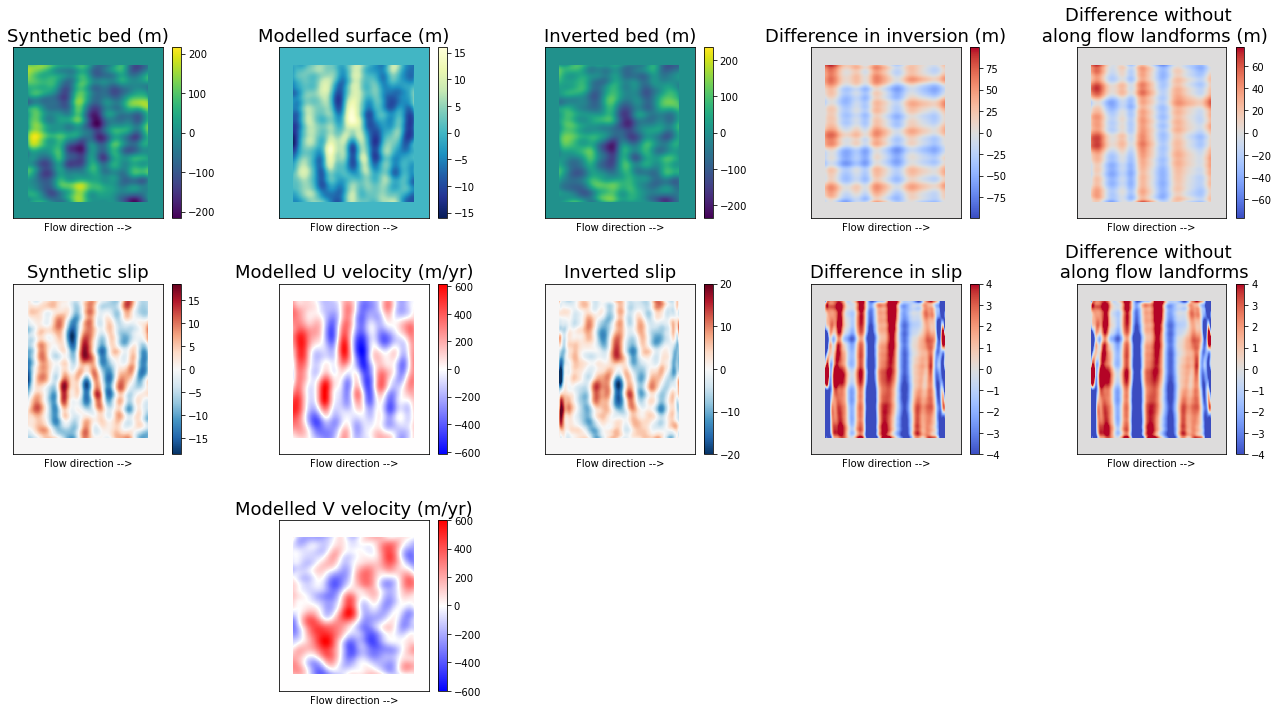

In [15]:
fig, ax = plt.subplots(3,5,figsize = (18,10))
edge = tap(B_inv, False)
plts = [[bed*edge, S*edge ,B_inv * edge, (bed - B_inv)*edge, B_true_diff*edge],\
        [slip*edge ,U*edge,C_inv*edge, (slip-C_inv)*edge, C_true_diff*edge],\
        [edge, V*edge, edge,edge,edge]]
cmap = [['viridis', 'YlGnBu_r', 'viridis', 'coolwarm','coolwarm'],\
        ['RdBu_r', 'bwr','RdBu_r','coolwarm','coolwarm'],\
        ['viridis', 'bwr','RdBu_r', 'RdBu_r','RdBu_r']]
titles = [['Synthetic bed (m)','Modelled surface (m)','Inverted bed (m)',\
           'Difference in inversion (m)','Difference without \n along flow landforms (m)'],\
         ['Synthetic slip','Modelled U velocity (m/yr)','Inverted slip',\
          'Difference in slip','Difference without \n along flow landforms'],\
         ['','Modelled V velocity (m/yr)','','','']]
im = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
cb = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
for i, j in itertools.product(range(3),range(5)):
    im[i][j] = ax[i,j].pcolor(plts[i][j], cmap = cmap[i][j])
    cb[i][j] = plt.colorbar(im[i][j], ax = ax[i,j])
    ax[i,j].get_xaxis().set_ticks([]); ax[i,j].get_yaxis().set_ticks([]);
    ax[i,j].set_xlabel('Flow direction -->')
    ax[i,j].set_title(titles[i][j], fontsize = 18)
    im[i][j].set_clim(-np.max(np.abs(plts[i][j])),np.max(np.abs(plts[i][j])))
ax[2,0].set_visible(False); cb[2][0].remove()
ax[2,2].set_visible(False); cb[2][2].remove()
ax[2,3].set_visible(False); cb[2][3].remove()
ax[2,4].set_visible(False); cb[2][4].remove()
im[0][2].set_clim(-np.max(np.abs(bed)), np.max(np.abs(bed)))
im[1][2].set_clim(-np.max(np.abs(slip)), np.max(np.abs(slip)))
im[1][3].set_clim(-4,4)
im[1][4].set_clim(-4,4)
fig.tight_layout()

In [16]:
## Setting any variables here 

m = 1 # Sliding law constant
C = 100 # Mean slipperiness
# Grid square parameters
square_size = 50000 # Grid width In m
spacing = 120 # Grid point spacing In m
tapering = 0.1 # Lose 10% on each side to tapering
# Model variables
alpha_s = 0.002 # 0.002
h_bar = 2000 # Mean Ice thickness In m
u_bar = 100 # Mean Ice velocity in m/yr
slope = 0
# Data error levels
p_b = -2
p_c = -2
erB = 0.001
erC = 0.001

size_of_grid = int(square_size/spacing)
x = np.arange(-size_of_grid *spacing/2, size_of_grid *spacing/2, spacing)
y = np.arange(-size_of_grid *spacing/2, size_of_grid *spacing/2, spacing)
x, y = np.meshgrid(x,y)

In [17]:
## To look at the response of the inversion to changes in the orientation of structures

In [18]:
def variable(theta_t_ar):
    beds = np.zeros(len(theta_t_ar), dtype = np.ndarray)
    slips = np.zeros(len(theta_t_ar), dtype = np.ndarray)
    B_invs = np.zeros(len(theta_t_ar), dtype = np.ndarray)
    C_invs = np.zeros(len(theta_t_ar), dtype = np.ndarray)
    for i in range(len(theta_t_ar)):
        beds[i] = grid_function(x,y,200,20000,theta_t_ar[i],0,form = 'Sinewave', across_lin = 2)
        slips[i] = grid_function(x,y,20,20000,theta_t_ar[i],0,form = 'Sinewave', across_lin = 2)
      #  gradient = -np.gradient(beds[i])[1] 
       # slips[i] = gradient / np.max(np.abs(gradient)) * 20
        S,U,V, B_invs[i], C_invs[i] = Identical_twin(beds[i], slips[i], alpha_s, C, Noise = True, 
                                                     amp_s = 2, amp_v = 15, erB = 0.001, erC = 0.001)    
    return beds, slips, B_invs, C_invs

theta_t_ar = (0,5, 15,20,25, 45,90)
beds, slips, B_invs, C_invs = variable(theta_t_ar)

C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_div

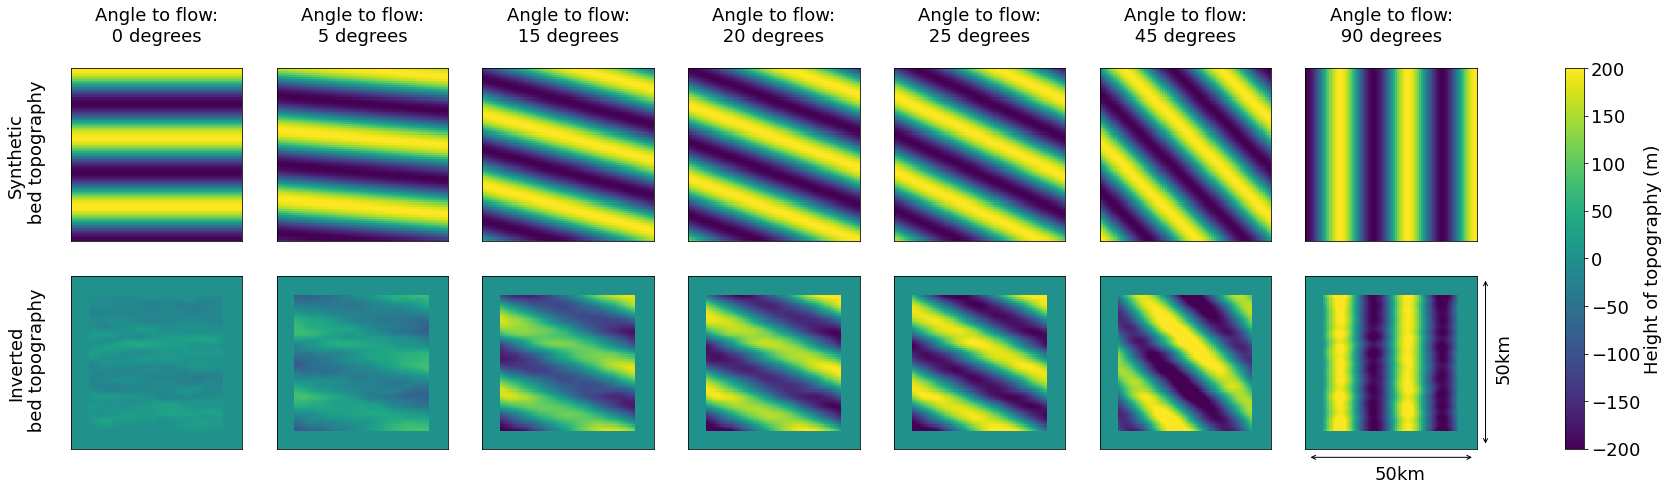

In [19]:
fig, ax = plt.subplots(2,len(theta_t_ar),figsize = (len(theta_t_ar)*4.5,7))
im = [[None] * len(theta_t_ar),[None] * len(theta_t_ar),[None] * len(theta_t_ar),[None] * len(theta_t_ar)]
for i in range(len(theta_t_ar)):
    im[0][i] = ax[0,i].pcolor(beds[i][::5,::5])
    ax[0][i].set_title('Angle to flow:\n {} degrees \n'.format(theta_t_ar[i]), fontsize = 18)
 #   im[0][0] = ax[0,0].pcolor(beds[0]*edge)
    im[1][i] = ax[1,i].pcolor((B_invs[i]*edge)[::5,::5])
 #   im[2][i] = ax[2,i].pcolor(slips[i], cmap = 'RdBu_r')
 #   im[3][i] = ax[3,i].pcolor(C_invs[i]*edge, cmap = 'RdBu_r')
for i,j in itertools.product(range(2), range(len(theta_t_ar))):
    im[0][j].set_clim(-200,200)
    im[1][j].set_clim(-200,200)
 #   im[2][j].set_clim(-20,20)
 #   im[3][j].set_clim(-20,20)
    ax[i,j].get_xaxis().set_ticks([]); ax[i,j].get_yaxis().set_ticks([]);
ax[0,0].set_ylabel('Synthetic\n bed topography\n', fontsize = 18)
ax[1,0].set_ylabel('Inverted\n bed topography\n', fontsize = 18)
#ax[2,0].set_ylabel('Synthetic\n bed slipperiness', fontsize = 16)
#ax[3,0].set_ylabel('Inverted\n bed slipperiness', fontsize = 16)
cb = plt.colorbar(im[0][0], ax = ax[:2,:]);
for t in cb.ax.get_yticklabels():
         t.set_fontsize(18)
cb.ax.set_ylabel('Height of topography (m)', fontsize = 18)
#plt.colorbar(im[2][0], ax = ax[2:,:]);
#fig.tight_layout()

# To add the arrows for scale to the bottom left plot
ax[1, len(theta_t_ar)-1].annotate("",
                xy=(0, -0.05), xycoords='axes fraction',
                xytext=(1, -0.05), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color="0",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle3,angleA=0,angleB=90",
                                ),)
ax[1, len(theta_t_ar)-1].annotate("50km", xy=(0, -0.05), xytext=(0.4, -0.18), 
                                  textcoords='axes fraction', color = "0", fontsize = 18)
ax[1, len(theta_t_ar)-1].annotate("",                
                xy=(1.05, 0), xycoords='axes fraction',
                xytext=(1.05, 1), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color="0",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle3,angleA=0,angleB=90",
                                ),)
ax[1, len(theta_t_ar)-1].annotate("50km", xy = (0,0), xytext=(1.1, 0.40), textcoords='axes fraction', 
                                  color = "0", rotation = 90, fontsize = 18)


fig.savefig('Angle_to_flow.jpg', bbox_inches = 'tight', dpi = 200, facecolor = 'none')
fig.savefig('Angle_to_flow.pdf', bbox_inches = 'tight', dpi = 200, facecolor = 'none')

In [20]:
# To look at changes in the wavelength of variability

In [21]:
def variable_wav(wavelength):
    beds = np.zeros(len(wavelength), dtype = np.ndarray)
    slips = np.zeros(len(wavelength), dtype = np.ndarray)
    B_invs = np.zeros(len(wavelength), dtype = np.ndarray)
    C_invs = np.zeros(len(wavelength), dtype = np.ndarray)
    for i in range(len(wavelength)):
        beds[i] = grid_function(x,y,200,wavelength[i],90,0,form = 'Sinewave', across_lin = 2)
        slips[i] = grid_function(x,y,20,wavelength[i],90,0,form = 'Sinewave', across_lin = 2)
      #  gradient = -np.gradient(beds[i])[1] 
       # slips[i] = gradient / np.max(np.abs(gradient)) * 20
        S,U,V, B_invs[i], C_invs[i] = Identical_twin(beds[i], slips[i], alpha_s, C, Noise = True, 
                                                     amp_s = 2, amp_v = 15, erB = 0.005, erC = 0.005)    
    return beds, slips, B_invs, C_invs

wavelength = (1000, 1500, 2000, 5000, 10000, 20000)
beds, slips, B_invs, C_invs = variable_wav(wavelength)

C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_div

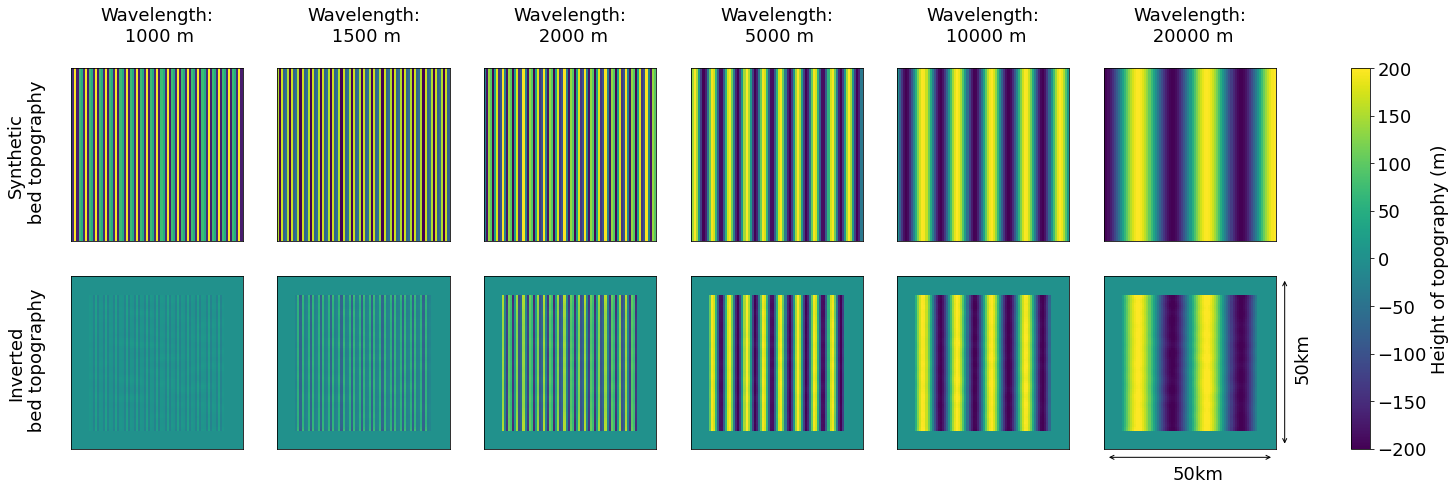

In [22]:
fig, ax = plt.subplots(2,len(wavelength),figsize = (len(wavelength)*4.5,7))
im = [[None] * len(wavelength),[None] * len(wavelength),[None] * len(wavelength),[None] * len(wavelength)]
for i in range(len(wavelength)):
    im[0][i] = ax[0,i].pcolor(beds[i][::5,::5])
    ax[0][i].set_title('Wavelength:\n {} m\n'.format(wavelength[i]), fontsize = 18)
    im[1][i] = ax[1,i].pcolor((B_invs[i]*edge)[::5,::5])
#    im[2][i] = ax[2,i].pcolor(slips[i], cmap = 'RdBu_r')
#    im[3][i] = ax[3,i].pcolor(C_invs[i]*edge, cmap = 'RdBu_r')
for i,j in itertools.product(range(2), range(len(wavelength))):
    im[0][j].set_clim(-200,200)
    im[1][j].set_clim(-200,200)
#    im[2][j].set_clim(-20,20)
#    im[3][j].set_clim(-20,20)
    ax[i,j].get_xaxis().set_ticks([]); ax[i,j].get_yaxis().set_ticks([]);
ax[0,0].set_ylabel('Synthetic\n bed topography\n', fontsize = 18)
ax[1,0].set_ylabel('Inverted\n bed topography\n', fontsize = 18)
#ax[2,0].set_ylabel('Synthetic\n bed slipperiness', fontsize = 18)
#ax[3,0].set_ylabel('Inverted\n bed slipperiness', fontsize = 18)
cb = plt.colorbar(im[0][0], ax = ax[:2,:]);
#cb2 = plt.colorbar(im[2][0], ax = ax[2:,:]);
#fig.tight_layout()
for t in cb.ax.get_yticklabels():
         t.set_fontsize(18)
cb.ax.set_ylabel('Height of topography (m)', fontsize = 18)
#for t in cb2.ax.get_yticklabels():
#         t.set_fontsize(18)
#cb2.ax.set_ylabel('Relative amplitude of slipperiness', fontsize = 18)


# To add the arrows for scale to the bottom left plot
ax[1, len(wavelength)-1].annotate("",
                xy=(0, -0.05), xycoords='axes fraction',
                xytext=(1, -0.05), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color="0",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle3,angleA=0,angleB=90",
                                ),)
ax[1, len(wavelength)-1].annotate("50km", xy=(0, -0.05), xytext=(0.4, -0.18), 
                                  textcoords='axes fraction', color = "0", fontsize = 18)
ax[1, len(wavelength)-1].annotate("",                
                xy=(1.05, 0), xycoords='axes fraction',
                xytext=(1.05, 1), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color="0",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle3,angleA=0,angleB=90",
                                ),)
ax[1, len(wavelength)-1].annotate("50km", xy = (0,0), xytext=(1.1, 0.40), textcoords='axes fraction', 
                                color = "0", rotation = 90, fontsize = 18)

fig.savefig('Wavelength.jpg', bbox_inches = 'tight', dpi = 200, facecolor = 'none')
fig.savefig('Wavelength.pdf', bbox_inches = 'tight', dpi = 200, facecolor = 'none')

In [23]:
# Looking at the influence of amplitude on resolution

In [24]:
def variable_amp(amplitude):
    beds = np.zeros(len(amplitude), dtype = np.ndarray)
    slips = np.zeros(len(amplitude), dtype = np.ndarray)
    B_invs = np.zeros(len(amplitude), dtype = np.ndarray)
    C_invs = np.zeros(len(amplitude), dtype = np.ndarray)
    for i in range(len(amplitude)):
        beds[i] = grid_function(x,y,amplitude[i],20000,60,0,form = 'Sinewave', across_lin = 2)
        slips[i] = grid_function(x,y,amplitude[i]/10,20000,60,0,form = 'Sinewave', across_lin = 2)
      #  gradient = -np.gradient(beds[i])[1] 
       # slips[i] = gradient / np.max(np.abs(gradient)) * 20
        S,U,V, B_invs[i], C_invs[i] = Identical_twin(beds[i], slips[i], alpha_s, C, Noise = True, amp_s = 2, amp_v = 15, \
                                                    erB = 0.001, erC = 0.001)   
    return beds, slips, B_invs, C_invs

amplitude = (0.5, 2, 5, 20,50, 200)
beds_a, slips_a, B_invs_a, C_invs_a = variable_amp(amplitude)

C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_div

In [25]:
bar_c = (u_bar / (1000 * 10 * 2000 * alpha_s * C))

In [26]:
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

 #   return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)
    return "\n Amplitude \n ${0:.{2}f}x10^{{{1:d}}}$ myr$^{{-1}}$Pa$^{{-1}}$"\
            .format(coeff, exponent, precision)

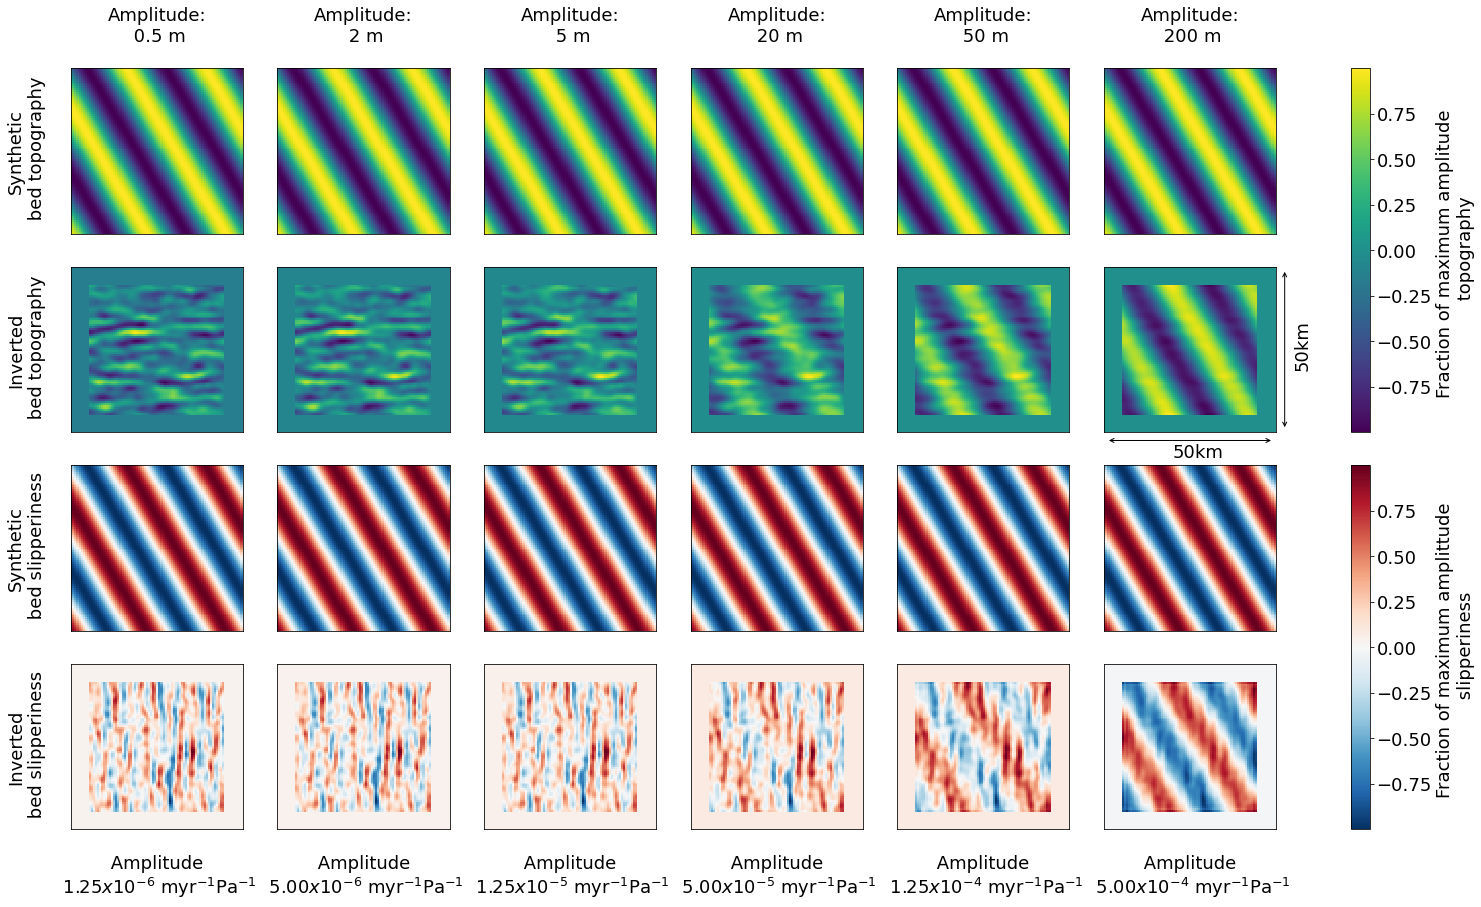

In [27]:
fig, ax = plt.subplots(4,len(amplitude),figsize = (len(amplitude)*4.5,14))
edge = tap(B_invs_a[0], False)
im = [[None] * len(amplitude),[None] * len(amplitude),[None] * len(amplitude),[None] * len(amplitude)]
for i in range(len(amplitude)):
    im[0][i] = ax[0,i].pcolor(beds_a[i][::5,::5]/np.max(np.abs(beds_a[i])))
    ax[0][i].set_title('Amplitude:\n {} m\n'.format(amplitude[i]), fontsize = 18)
    #ax[3,i].set_xlabel('\nAmplitude:\n {} mm yr$^{{-1}}$ Pa$^{{-1}}$'.format(amplitude[i]/10 * bar_c), 
    #                   fontsize = 18)
    ax[3,i].set_xlabel(sci_notation(amplitude[i]/10 * bar_c,2),
                       fontsize = 18)
    im[1][i] = ax[1,i].pcolor((B_invs_a[i]*edge)[::5,::5]/np.max(np.abs(B_invs_a[i])))
    im[2][i] = ax[2,i].pcolor(slips_a[i][::5,::5]/np.max(np.abs(slips_a[i])), cmap = 'RdBu_r')
    im[3][i] = ax[3,i].pcolor((C_invs_a[i]*edge)[::5,::5]/np.max(np.abs(C_invs_a[i])), cmap = 'RdBu_r')
for i,j in itertools.product(range(4), range(len(amplitude))):
#    im[0][j].set_clim(-200,200)
#    im[1][j].set_clim(-200,200)
#    im[2][j].set_clim(-20,20)
#    im[3][j].set_clim(-20,20)
    ax[i,j].get_xaxis().set_ticks([]); ax[i,j].get_yaxis().set_ticks([]);
ax[0,0].set_ylabel('Synthetic\n bed topography\n', fontsize = 18)
ax[1,0].set_ylabel('Inverted\n bed topography\n', fontsize = 18)
ax[2,0].set_ylabel('Synthetic\n bed slipperiness\n', fontsize = 18)
ax[3,0].set_ylabel('Inverted\n bed slipperiness\n', fontsize = 18)
cb = plt.colorbar(im[0][0], ax = ax[:2,:]);
cb2 = plt.colorbar(im[2][0], ax = ax[2:,:]);
#fig.tight_layout()
for t in cb.ax.get_yticklabels():
         t.set_fontsize(18)
cb.ax.set_ylabel('Fraction of maximum amplitude \n topography', fontsize = 18)
for t in cb2.ax.get_yticklabels():
         t.set_fontsize(18)
cb2.ax.set_ylabel('Fraction of maximum amplittude \n slipperiness', fontsize = 18)

# To add the arrows for scale to the bottom left plot
ax[1, len(amplitude)-1].annotate("",
                xy=(0, -0.05), xycoords='axes fraction',
                xytext=(1, -0.05), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color="0",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle3,angleA=0,angleB=90",
                                ),)
ax[1, len(amplitude)-1].annotate("50km", xy=(0, -0.05), xytext=(0.4, -0.15), 
                                  textcoords='axes fraction', color = "0", fontsize = 18)
ax[1, len(amplitude)-1].annotate("",                
                xy=(1.05, 0), xycoords='axes fraction',
                xytext=(1.05, 1), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color="0",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle3,angleA=0,angleB=90",
                                ),)
ax[1, len(amplitude)-1].annotate("50km", xy = (0,0), xytext=(1.1, 0.40), textcoords='axes fraction', 
                                color = "0", rotation = 90, fontsize = 18)


#plt.colorbar(im[2][0], ax = ax[2:,:]);
#fig.tight_layout()
fig.savefig('Amplitude.jpg', bbox_inches = 'tight', dpi = 200, facecolor = 'none')
fig.savefig('Amplitude.pdf', bbox_inches = 'tight', dpi = 200, facecolor = 'none')